# 1. Introduction: nilearn in a nutshell

In [1]:
# First thing, we can map a statistic image onto a glass brain

In [2]:
from nilearn import plotting

//anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


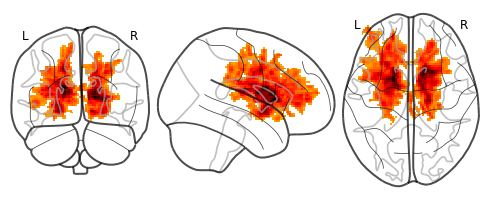

In [4]:
plotting.plot_glass_brain("/Users/u4307082/Desktop/python/nilearn/thresh_zstat1.nii.gz")

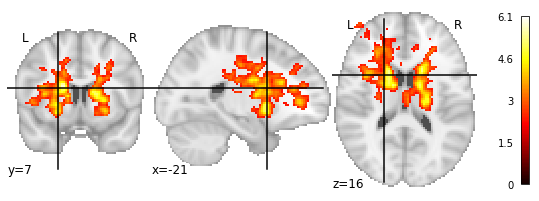

In [5]:
plotting.plot_stat_map("/Users/u4307082/Desktop/python/nilearn/thresh_zstat1.nii.gz")

When used in non-interactive settings, such as a script or program, these figures are not displayed by default, but still accumulate and eventually lead to slowing the execution and running out of memory. To avoid this you should do the following:

form nilearn import plotting
display = plotting.plot_glass_brain("/Users/u4307082/Desktop/python/nilearn/thresh_zstat1.nii.gz")
display.close()

You can do image smoothing quite easily using image.smooth_img

In [7]:
from nilearn import image
smoothed_img = image.smooth_img("/Users/u4307082/Desktop/python/nilearn/thresh_zstat1.nii.gz", fwhm=5)

Now we need to convert our nifti object to a figure

In [8]:
smoothed_img.to_filename("/Users/u4307082/Desktop/python/nilearn/thresh_zstat1_5mm.nii.gz")

### 8.3.10 VBM on the Oasis dataset

For this project we are going to predict age from the VBM data (n = 100, usually much higher).

We run a standard SVM-ANOVA nilearn pipeline to predice age from the VBM data.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets
from nilearn.input_data import NiftiMasker

n_subjects = 100

#### Now we need to load our dataset(oasis)

In [26]:
oasis_dataset = datasets.fetch_oasis_vbm(n_subjects=n_subjects)
gray_matter_map_filenames = oasis_dataset.gray_matter_maps
age = oasis_dataset.ext_vars['age'].astype(float)

//anaconda3/lib/python3.7/site-packages/numpy/lib/npyio.py:2322: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [27]:
print('First gray-matter anatomy image (3D) is located at: %s' %
      oasis_dataset.gray_matter_maps[0])
print('\n')
print('First white-matter anatomy image (3D) is located at: %s' %
      oasis_dataset.white_matter_maps[0])

First gray-matter anatomy image (3D) is located at: /Users/u4307082/nilearn_data/oasis1/OAS1_0001_MR1/mwrc1OAS1_0001_MR1_mpr_anon_fslswapdim_bet.nii.gz


First white-matter anatomy image (3D) is located at: /Users/u4307082/nilearn_data/oasis1/OAS1_0001_MR1/mwrc2OAS1_0001_MR1_mpr_anon_fslswapdim_bet.nii.gz


#### Preprocess data

In [28]:
nifti_masker = NiftiMasker(
    standardize=False,
    smoothing_fwhm=2,
    memory='nilearn_cache') #cache options

gm_maps_masked = nifti_masker.fit_transform(gray_matter_map_filenames)
n_samples, n_features = gm_maps_masked.shape
print("%d samples, %d features" % (n_subjects, n_features))

100 samples, 902629 features


Here we need to define the function that is to be used. In this example we are wokring with a Support Vector Classification, with a linear kernel

In [29]:
print("ANOVA + SVR")
# Define the prediction function to be used.
# Here we use a Support Vector Classification, with a linear kernel
from sklearn.svm import SVR
svr = SVR(kernel='linear')

# Dimension reduction
from sklearn.feature_selection import VarianceThreshold, SelectKBest, \
        f_regression

# Remove features with too low between-subject variance
variance_threshold = VarianceThreshold(threshold=.01)

# Here we use a classical univariate feature selection based on F-test,
# namely Anova.
feature_selection = SelectKBest(f_regression, k=2000)

# We have our predictor (SVR), our feature selection (SelectKBest), and now,
# we can plug them together in a *pipeline* that performs the two operations
# successively:
from sklearn.pipeline import Pipeline
anova_svr = Pipeline([
            ('variance_threshold', variance_threshold),
            ('anova', feature_selection),
            ('svr', svr)])

### Fit and predict
anova_svr.fit(gm_maps_masked, age)
age_pred = anova_svr.predict(gm_maps_masked)

ANOVA + SVR


#### Visualisation

/Users/u4307082/.local/lib/python3.7/site-packages/nilearn/plotting/displays.py:1582: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])
//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


=== ANOVA ===
Prediction accuracy: 0.736385

Massively univariate model


/Users/u4307082/.local/lib/python3.7/site-packages/nilearn/plotting/displays.py:1582: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])



1892 detections


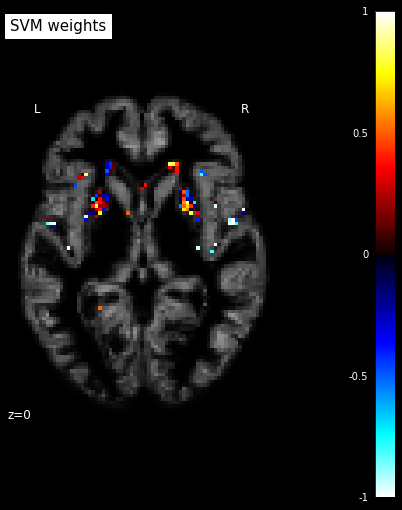

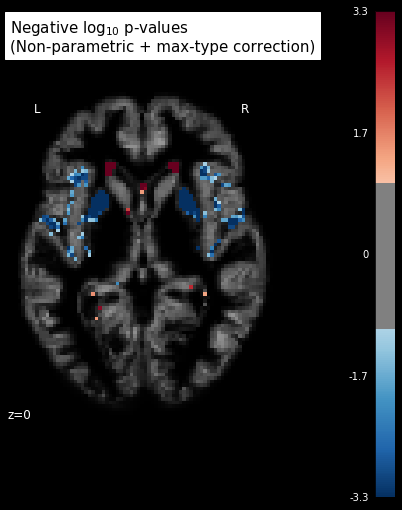

In [30]:
coef = svr.coef_
# reverse feature selection
coef = feature_selection.inverse_transform(coef)
# reverse variance threshold
coef = variance_threshold.inverse_transform(coef)
# reverse masking
weight_img = nifti_masker.inverse_transform(coef)

# Create the figure
from nilearn.plotting import plot_stat_map, show
bg_filename = gray_matter_map_filenames[0]
z_slice = 0


fig = plt.figure(figsize=(5.5, 7.5), facecolor='k')
# Hard setting vmax to highlight weights more
display = plot_stat_map(weight_img, bg_img=bg_filename,
                        display_mode='z', cut_coords=[z_slice],
                        figure=fig, vmax=1)
display.title('SVM weights', y=1.2)

# Measure accuracy with cross validation
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(anova_svr, gm_maps_masked, age)

# Return the corresponding mean prediction accuracy
prediction_accuracy = np.mean(cv_scores)
print("=== ANOVA ===")
print("Prediction accuracy: %f" % prediction_accuracy)
print("")

### Inference with massively univariate model #################################
print("Massively univariate model")

# Statistical inference
from nilearn.mass_univariate import permuted_ols
data = variance_threshold.fit_transform(gm_maps_masked)
neg_log_pvals, t_scores_original_data, _ = permuted_ols(
    age, data,  # + intercept as a covariate by default
    n_perm=2000,  # 1,000 in the interest of time; 10000 would be better
    n_jobs=1)  # can be changed to use more CPUs
signed_neg_log_pvals = neg_log_pvals * np.sign(t_scores_original_data)
signed_neg_log_pvals_unmasked = nifti_masker.inverse_transform(
    variance_threshold.inverse_transform(signed_neg_log_pvals))

# Show results
threshold = -np.log10(0.1)  # 10% corrected

fig = plt.figure(figsize=(5.5, 7.5), facecolor='k')

display = plot_stat_map(signed_neg_log_pvals_unmasked, bg_img=bg_filename,
                        threshold=threshold, cmap=plt.cm.RdBu_r,
                        display_mode='z', cut_coords=[z_slice],
                        figure=fig)
title = ('Negative $\log_{10}$ p-values'
         '\n(Non-parametric + max-type correction)')
display.title(title, y=1.2)

n_detections = (signed_neg_log_pvals_unmasked.get_data() > threshold).sum()
print('\n%d detections' % n_detections)

show()